# Classification of Documents

#### A couple of additional tools and basic imports to be used below

In [2]:
#General Imports
import pickle

In [3]:
#convert Unicode object to ASCII strings
from django.utils.encoding import smart_str, smart_unicode 
def convertU(data):
    if isinstance(data, basestring):
        return smart_str(data)
    elif isinstance(data, collections.Mapping):
        return dict(map(convertU, data.iteritems()))
    elif isinstance(data, collections.Iterable):
        return type(data)(map(convertU, data))
    else:
        return data

### Connect to Database

In [3]:
from pymongo import MongoClient
# Connect to the mongo local database
connection = MongoClient()
db = connection.bsa_files
collection = db.bsa_files

### Classification Toolset

In [4]:
#full packages
import string
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import re
import os
import codecs

#sklearn tools
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances 
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
from sklearn.externals import joblib

#nltk tools
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


#scipy tools
from scipy.cluster.hierarchy import ward, dendrogram

#gensim
from gensim import corpora, models, similarities 

C:\Users\ajwil\Anaconda2\lib\site-packages\gensim\utils.py:840: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### Working file lists & dicts

In [5]:
working_uid_list =  pickle.load(open('working_uid_list.pickle','r'))
working_hash_dict = pickle.load(open('working_hash_dict.pickle','r'))
content_hash_dict = pickle.load(open('content_hash_dict.pickle','r'))
unique_content_hash_list = pickle.load(open('unique_content_hash_list.pickle','r'))

#Validate
print(len(working_uid_list))
print(len(working_hash_dict))
print(len(content_hash_dict))
print(len(unique_content_hash_list))

36549
5546
4221
4221


### Create Text Corpus

In [38]:
english_text_corpus = []
english_text_names = []
spanish_text_corpus = []
spanish_text_names = []

for unique_hash in unique_content_hash_list:
    document = collection.find_one({"Content_Hash":unique_hash})
    if document["Content"]!=None and len(document["Content"])>1:
        if document["Language"]=='english':
            english_text_corpus.append(document["Content"])
            english_text_names.append(document["File_Name"])
        elif document["Language"]=='spanish':
            spanish_text_corpus.append(document["Content"])
            spanish_text_names.append(document["File_Name"])

with open('bsa_english_corpus.pickle','w') as p:
    pickle.dump(english_text_corpus,p)
with open('bsa_spanish_corpus.pickle','w') as q:
    pickle.dump(spanish_text_corpus,q)
with open('bsa_english_document_names.pickle','w') as r:
    pickle.dump(english_text_names,r)
with open('bsa_spanish_document_names.pickle','w') as s:
    pickle.dump(spanish_text_names,s)

In [39]:
print("English Documents for Classification: {}".format(len(english_text_corpus)))
print("Spanish Documents for Classification: {}".format(len(spanish_text_corpus)))
print("English Documents Names: {}".format(len(english_text_names)))
print("Spanish Documents Names: {}".format(len(spanish_text_names)))

English Documents for Classification: 3979
Spanish Documents for Classification: 240
English Documents Names: 3979
Spanish Documents Names: 240


In [40]:
english_text_corpus = pickle.load(open('bsa_english_corpus.pickle','r'))
spanish_text_corpus = pickle.load(open('bsa_spanish_corpus.pickle','r'))
english_text_names = pickle.load(open('bsa_english_document_names.pickle','r'))
spanish_text_names = pickle.load(open('bsa_spanish_document_names.pickle','r'))

# Process Text Corpus
    Remove Stopwords, punctuations and stem

In [15]:
#special stopwords to remove common scouting terms and other erroneous text that continually showed up in the results
bsa_stop_words = ['scout','boy','cub','train','council',
                  'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']

### Stopwords, Stemming and Tokenizer

In [16]:
english_stopwords = stopwords.words('english') + bsa_stop_words
spanish_stopwords = stopwords.words('spanish') + bsa_stop_words + stopwords.words('english')

english_stemmer = SnowballStemmer("english")
spanish_stemmer = SnowballStemmer("spanish")

def tokenize_and_stem_english(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [english_stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_and_stem_spanish(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [spanish_stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens



### Implement stemming and tokenizing

In [43]:
english_vocab_stemmed = []
english_vocab_tokenized = []
spanish_vocab_stemmed = []
spanish_vocab_tokenized = []

for e in english_text_corpus:
    words_stemmed = tokenize_and_stem_english(e)
    english_vocab_stemmed.extend(words_stemmed)
    words_tokenized = tokenize_only(e)
    english_vocab_tokenized.extend(words_tokenized)

for s in spanish_text_corpus:
    words_stemmed = tokenize_and_stem_spanish(s)
    spanish_vocab_stemmed.extend(words_stemmed)
    words_tokenized = tokenize_only(s)
    spanish_vocab_tokenized.extend(words_tokenized)
    
with open('english_vocab_stemmed.pickle','w') as p:
    pickle.dump(english_vocab_stemmed,p)
with open('english_vocab_tokenized.pickle','w') as q:
    pickle.dump(english_vocab_tokenized,q)
with open('spanish_vocab_stemmed.pickle','w') as r:
    pickle.dump(spanish_vocab_stemmed,r)
with open('spanish_vocab_tokenized.pickle','w') as s:
    pickle.dump(spanish_vocab_tokenized,s)

### Initialize Dataframes

In [44]:
english_vocab_frame = pd.DataFrame({'words':english_vocab_tokenized}, index = english_vocab_stemmed)
print('There are {} items in english_vocab_frame'.format(str(english_vocab_frame.shape[0])))

spanish_vocab_frame = pd.DataFrame({'words':spanish_vocab_tokenized}, index = spanish_vocab_stemmed)
print('There are {} items in spanish_vocab_frame'.format(str(spanish_vocab_frame.shape[0])))

with open('english_vocab_frame.pickle','w') as p:
    pickle.dump(english_vocab_frame,p)
with open('spanish_vocab_frame.pickle','w') as q:
    pickle.dump(spanish_vocab_frame,q)

There are 10947405 items in english_vocab_frame
There are 1986384 items in spanish_vocab_frame


In [45]:
english_vocab_frame = pickle.load(open('english_vocab_frame.pickle','r'))
spanish_vocab_frame = pickle.load(open('spanish_vocab_frame.pickle','r'))

### TF-IDF Vectorization

In [46]:
english_tfidf_vectorizer = TfidfVectorizer(max_df=0.8, 
                                           max_features=200000,
                                           min_df=0.2, 
                                           stop_words=english_stopwords,
                                           use_idf=True, 
                                           tokenizer=tokenize_and_stem_english, 
                                           ngram_range=(1,3))

spanish_tfidf_vectorizer = TfidfVectorizer(max_df=0.8, 
                                           max_features=200000,
                                           min_df=0.2, 
                                           stop_words=spanish_stopwords,
                                           use_idf=True, 
                                           tokenizer=tokenize_and_stem_spanish, 
                                           ngram_range=(1,3))

english_tfidf_matrix = english_tfidf_vectorizer.fit_transform(english_text_corpus)
print(english_tfidf_matrix.shape)

spanish_tfidf_matrix = spanish_tfidf_vectorizer.fit_transform(spanish_text_corpus)
print(spanish_tfidf_matrix.shape)

(3979, 313)
(240, 790)


In [47]:
english_terms = english_tfidf_vectorizer.get_feature_names()
spanish_terms = spanish_tfidf_vectorizer.get_feature_names()

In [48]:
english_dist = 1-cosine_similarity(english_tfidf_matrix)
spanish_dist = 1-cosine_similarity(spanish_tfidf_matrix)

In [49]:
with open('english_tfidf_matrix.pickle','w') as a:
    pickle.dump(english_tfidf_matrix,a)
with open('spanish_tfidf_matrix.pickle','w') as b:
    pickle.dump(spanish_tfidf_matrix,b)
with open('english_terms.pickle','w') as c:
    pickle.dump(english_terms,c)
with open('spanish_terms.pickle','w') as d:
    pickle.dump(spanish_terms,d)
with open('english_dist.pickle','w') as e:
    pickle.dump(english_dist,e)
with open('spanish_dist.pickle','w') as f:
    pickle.dump(spanish_dist,f)

### Re-load data to start at classification

In [6]:
english_tfidf_matrix = pickle.load(open('english_tfidf_matrix.pickle','r'))
spanish_tfidf_matrix = pickle.load(open('spanish_tfidf_matrix.pickle','r'))

english_terms = pickle.load(open('english_terms.pickle','r'))
spanish_terms = pickle.load(open('spanish_terms.pickle','r'))

english_dist = pickle.load(open('english_dist.pickle','r'))
spanish_dist = pickle.load(open('spanish_dist.pickle','r'))

english_text_names = pickle.load(open('bsa_english_document_names.pickle','r'))
spanish_text_names = pickle.load(open('bsa_spanish_document_names.pickle','r'))

english_text_corpus = pickle.load(open('bsa_english_corpus.pickle','r'))
spanish_text_corpus = pickle.load(open('bsa_spanish_corpus.pickle','r'))

english_vocab_frame = pickle.load(open('english_vocab_frame.pickle','r'))
spanish_vocab_frame = pickle.load(open('spanish_vocab_frame.pickle','r'))

### K-Means Classification / Clustering

In [50]:
num_english_clusters = 6
num_spanish_clusters = 4

english_km = KMeans(n_clusters = num_english_clusters)
spanish_km = KMeans(n_clusters = num_spanish_clusters)

english_km.fit(english_tfidf_matrix)
spanish_km.fit(spanish_tfidf_matrix)

english_clusters = english_km.labels_.tolist()
spanish_clusters = spanish_km.labels_.tolist()

joblib.dump(english_km, 'english_km.pkl')
joblib.dump(spanish_km, 'spanish_km.pkl')

['spanish_km.pkl', 'spanish_km.pkl_01.npy', 'spanish_km.pkl_02.npy']

In [7]:
english_km = joblib.load('english_km.pkl')
spanish_km = joblib.load('spanish_km.pkl')

english_clusters = english_km.labels_.tolist()
spanish_clusters = spanish_km.labels_.tolist()

In [8]:
english_documents = {'name':english_text_names,
                    'text':english_text_corpus,
                    'cluster':english_clusters}
spanish_documents = {'name':spanish_text_names,
                    'text':spanish_text_corpus,
                    'cluster':spanish_clusters}

english_df =pd.DataFrame(english_documents, 
                         index = [english_clusters], 
                         columns = ['name','text','cluster'])

spanish_df =pd.DataFrame(spanish_documents, 
                         index = [spanish_clusters], 
                         columns = ['name','text','cluster'])

### Identify Clusters by keywords

In [52]:
from __future__ import print_function

print("Top Terms per English Cluster")
print()

order_centroids = english_km.cluster_centers_.argsort()[:, ::-1] 

for i in range (num_english_clusters):
    
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        print(' %s' % english_vocab_frame.ix[english_terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print()
    print()
    
    print("Cluster %d Size:" % i, end='')
    print(len(english_df.ix[i]['name'].values.tolist()))
    #for name in english_df.ix[i]['name'].values.tolist():
        #print(' %s,' % name, end='')
    print()
    print()

Top Terms per English Cluster

Cluster 0 words: camp, program, area, regional, staff, may,

Cluster 0 Size:128


Cluster 1 words: awards, dates, name, approval, completing, committee,

Cluster 1 Size:252


Cluster 2 words: national, order, regional, service, program, section,

Cluster 2 Size:203


Cluster 3 words: units, district, service, tools, organizing, program,

Cluster 3 Size:348


Cluster 4 words: advancement, badge, merit, required, committee, issue,

Cluster 4 Size:93


Cluster 5 words: bases, report, using, dates, part, name,

Cluster 5 Size:1189


Cluster 6 words: program, youth, active, participate, leaders, bsa,

Cluster 6 Size:904


Cluster 7 words: meeting, one, times, make, using, active,

Cluster 7 Size:546


Cluster 8 words: adventure, building, bases, get, take, started,

Cluster 8 Size:132


Cluster 9 words: http, website, merit, explain, badge, following,

Cluster 9 Size:184




In [20]:
print("Top Terms per Spanish Cluster")
print()

order_centroids = spanish_km.cluster_centers_.argsort()[:, ::-1] 

for i in range (num_spanish_clusters):
    
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        print(' %s' % spanish_vocab_frame.ix[spanish_terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print()
    print()
    
    print("Cluster %d Size:" % i, end='')
    print(len(spanish_df.ix[i]['name'].values.tolist()))
    #for name in spanish_df.ix[i]['name'].values.tolist():
    #    print(' %s,' % name, end='')
    print()
    print()

Top Terms per Spanish Cluster

Cluster 0 words: den, jugadores, pack, niños, minute, juego,

Cluster 0 Size:42


Cluster 1 words: scouting, program, scouts, cómo, pueda, debe,

Cluster 1 Size:98


Cluster 2 words: venturers, major, parte, recorrido, saben, seunscout.org,

Cluster 2 Size:32


Cluster 3 words: seunscout.org, para, based, aventura, based, gran,

Cluster 3 Size:68




In [ ]:
colors = ["#000000","#FFFF00","#1CE6FF","#FF34FF","#FF4A46","#008941",
 "#006FA6","#A30059","#FFDBE5","#7A4900","#0000A6","#63FFAC",
 "#B79762","#004D43","#8FB0FF","#997D87","#5A0007","#809693",
 "#FEFFE6","#1B4400","#4FC601","#3B5DFF","#4A3B53","#FF2F80",
 "#61615A","#BA0900","#6B7900","#00C2A0","#FFAA92","#FF90C9",
 "#B903AA","#D16100","#DDEFFF","#000035","#7B4F4B","#A1C299",
 "#300018","#0AA6D8","#013349","#00846F","#372101","#FFB500",
 "#C2FFED","#A079BF","#CC0744","#C0B9B2","#C2FF99","#001E09",
 "#00489C","#6F0062","#0CBD66","#EEC3FF","#456D75","#B77B68",
 "#7A87A1","#788D66","#885578","#FAD09F","#FF8A9A","#D157A0",
 "#BEC459","#456648","#0086ED","#886F4C","#34362D","#B4A8BD",
 "#00A6AA","#452C2C","#636375","#A3C8C9","#FF913F","#938A81",
 "#575329","#00FECF","#B05B6F","#8CD0FF","#3B9700","#04F757",
 "#C8A1A1","#1E6E00","#7900D7","#A77500","#6367A9","#A05837",
 "#6B002C","#772600","#D790FF","#9B9700","#549E79","#FFF69F",
 "#201625","#72418F","#BC23FF","#99ADC0","#3A2465","#922329",
 "#5B4534","#FDE8DC","#404E55","#0089A3","#CB7E98","#A4E804",
 "#324E72","#6A3A4C","#83AB58","#001C1E","#D1F7CE","#004B28",
 "#C8D0F6","#A3A489","#806C66","#222800","#BF5650","#E83000",
 "#66796D","#DA007C","#FF1A59","#8ADBB4","#1E0200","#5B4E51",
 "#C895C5","#320033","#FF6832","#66E1D3","#CFCDAC","#D0AC94",
 "#7ED379","#012C58","#7A7BFF","#D68E01","#353339","#78AFA1",
 "#FEB2C6","#75797C","#837393","#943A4D","#B5F4FF","#D2DCD5",
 "#9556BD","#6A714A","#001325","#02525F","#0AA3F7","#E98176",
 "#DBD5DD","#5EBCD1","#3D4F44","#7E6405","#02684E","#962B75",
 "#8D8546","#9695C5","#E773CE","#D86A78","#3E89BE","#CA834E",
 "#518A87","#5B113C","#55813B","#E704C4","#00005F","#A97399",
 "#4B8160","#59738A","#FF5DA7","#F7C9BF","#643127","#513A01",
 "#6B94AA","#51A058","#A45B02","#1D1702","#E20027","#E7AB63",
 "#4C6001","#9C6966","#64547B","#97979E","#006A66","#391406",
 "#F4D749","#0045D2","#006C31","#DDB6D0","#7C6571","#9FB2A4",
 "#00D891","#15A08A","#BC65E9","#FFFFFE","#C6DC99","#203B3C",
 "#671190","#6B3A64","#F5E1FF","#FFA0F2","#CCAA35","#374527",
 "#8BB400","#797868","#C6005A","#3B000A","#C86240","#29607C",
 "#402334","#7D5A44","#CCB87C","#B88183","#AA5199","#B5D6C3",
 "#A38469","#9F94F0","#A74571","#B894A6","#71BB8C","#00B433",
 "#789EC9","#6D80BA","#953F00","#5EFF03","#E4FFFC","#1BE177",
 "#BCB1E5","#76912F","#003109","#0060CD","#D20096","#895563",
 "#29201D","#5B3213","#A76F42","#89412E","#1A3A2A","#494B5A",
 "#A88C85","#F4ABAA","#A3F3AB","#00C6C8","#EA8B66","#958A9F",
 "#BDC9D2","#9FA064","#BE4700","#658188","#83A485","#453C23",
 "#47675D","#3A3F00","#061203","#DFFB71","#868E7E","#98D058",
 "#6C8F7D","#D7BFC2","#3C3E6E","#D83D66","#2F5D9B","#6C5E46",
 "#D25B88","#5B656C","#00B57F","#545C46","#866097","#365D25",
 "#252F99","#00CCFF","#674E60","#FC009C","#92896B"]

### Graph Clusters

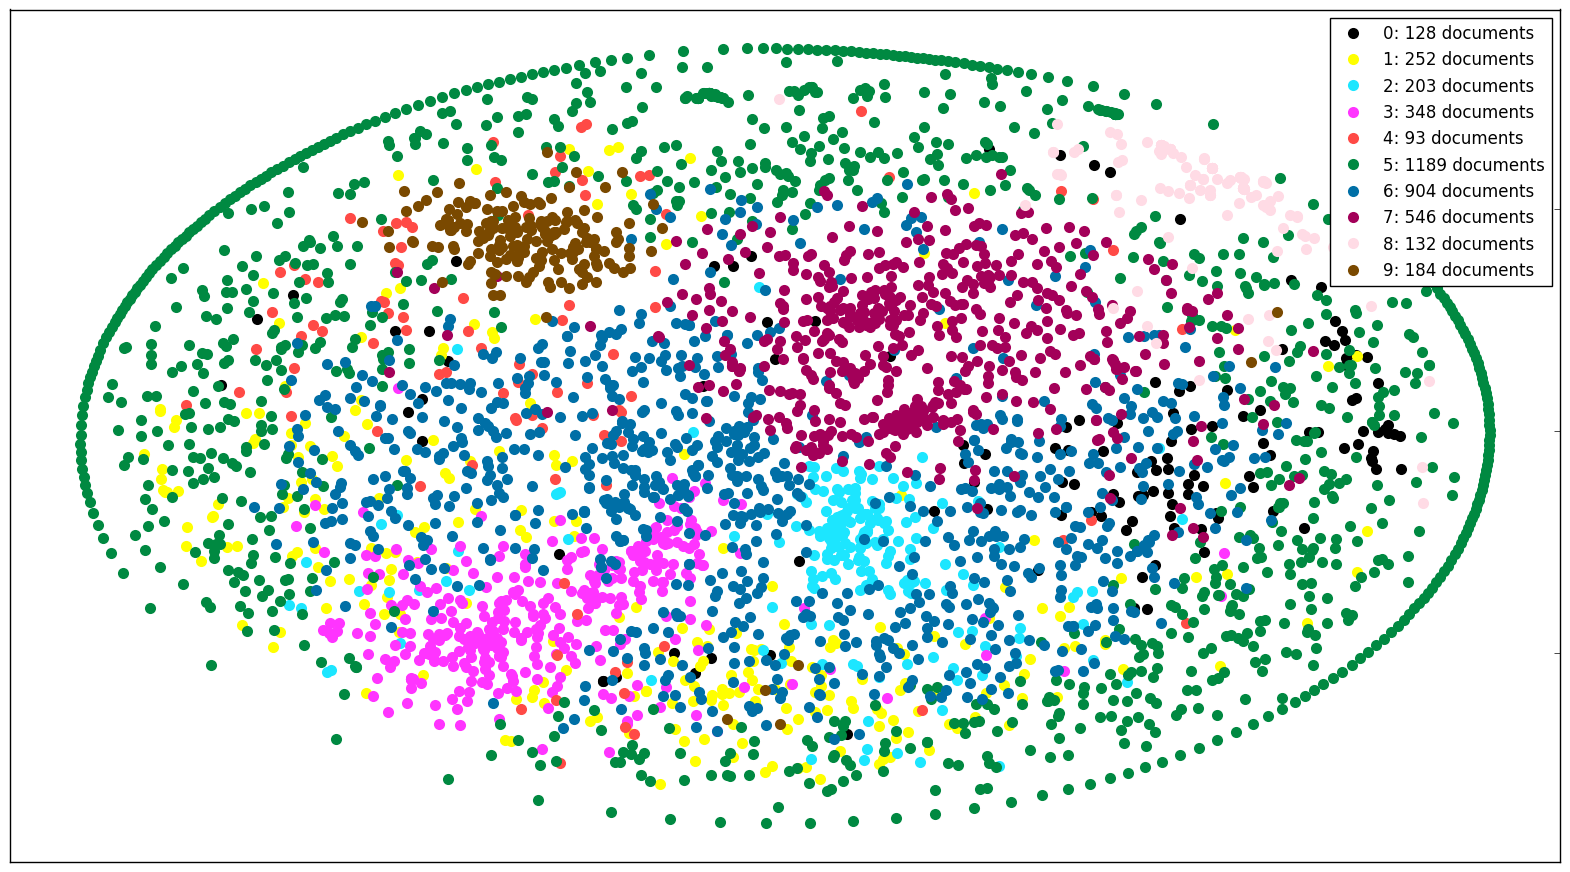

In [53]:
MDS()

mds = MDS(n_components = 2, dissimilarity = "precomputed", random_state=1)

pos = mds.fit_transform(english_dist)

xs, ys = pos[:, 0], pos[:, 1]

cluster_colors = {0: "#000000",
                 1: "#FFFF00",
                 2: "#1CE6FF",
                 3: "#FF34FF",
                 4: "#FF4A46",
                 5: "#008941"}#,
#                 6: "#006FA6",
#                 7: "#A30059",
#                 8: "#FFDBE5",
#                 9: "#7A4900",
#                 10: "#0000A6",
#                 11: "#63FFAC",
#                 12: "#B79762",
#                 13: "#004D43",
#                 14: "#8FB0FF"}

cluster_names = {0: '0: {} documents'.format((len(english_df.ix[0]['name'].values.tolist()))),
                 1: '1: {} documents'.format((len(english_df.ix[1]['name'].values.tolist()))),
                 2: '2: {} documents'.format((len(english_df.ix[2]['name'].values.tolist()))), 
                 3: '3: {} documents'.format((len(english_df.ix[3]['name'].values.tolist()))),
                 4: '4: {} documents'.format((len(english_df.ix[4]['name'].values.tolist()))),
                 5: '5: {} documents'.format((len(english_df.ix[5]['name'].values.tolist())))}#,
#                 6: '6: {} documents'.format((len(english_df.ix[6]['name'].values.tolist()))),
#                 7: '7: {} documents'.format((len(english_df.ix[7]['name'].values.tolist()))),
#                 8: '8: {} documents'.format((len(english_df.ix[8]['name'].values.tolist()))),
#                 9: '9: {} documents'.format((len(english_df.ix[9]['name'].values.tolist()))),
#                 10: '10: {} documents'.format((len(english_df.ix[10]['name'].values.tolist()))),
#                 11: '11: {} documents'.format((len(english_df.ix[11]['name'].values.tolist()))),
#                 12: '12: {} documents'.format((len(english_df.ix[12]['name'].values.tolist()))),
#                 13: '13: {} documents'.format((len(english_df.ix[13]['name'].values.tolist()))),
#                 14: '14: {} documents'.format((len(english_df.ix[14]['name'].values.tolist())))}

df = pd.DataFrame(dict(x=xs, y=ys, label=english_clusters, name=english_text_names)) 

groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(20, 11)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=8, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the document name
#for i in range(len(df)):
#    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['name'], size=8)  

    
    
plt.show()

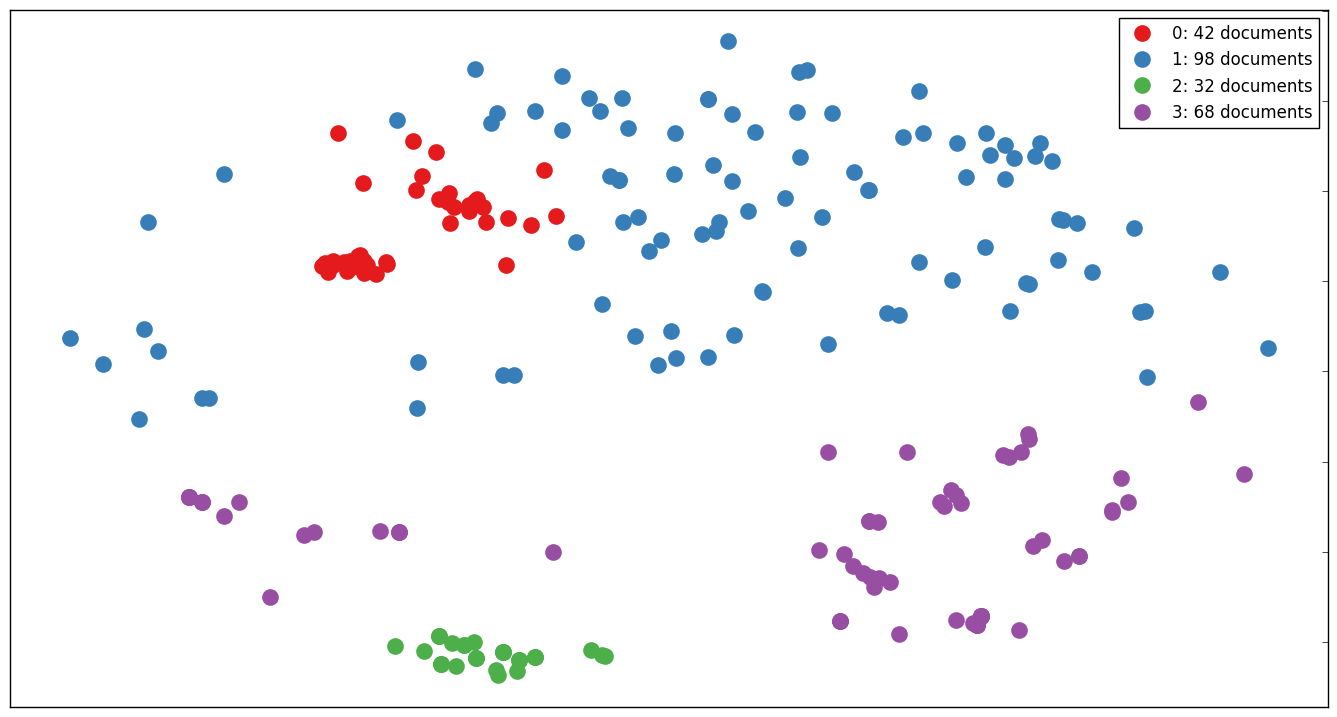

In [24]:
MDS()

mds = MDS(n_components = 2, dissimilarity = "precomputed", random_state=1)

pos = mds.fit_transform(spanish_dist)

xs, ys = pos[:, 0], pos[:, 1]

cluster_colors = {0: '#e41a1c',
                 1: '#377eb8',
                 2: '#4daf4a',
                 3: '#984ea3'}

cluster_names = {0: '0: {} documents'.format((len(spanish_df.ix[0]['name'].values.tolist()))),
                 1: '1: {} documents'.format((len(spanish_df.ix[1]['name'].values.tolist()))),
                 2: '2: {} documents'.format((len(spanish_df.ix[2]['name'].values.tolist()))), 
                 3: '3: {} documents'.format((len(spanish_df.ix[3]['name'].values.tolist())))}

df = pd.DataFrame(dict(x=xs, y=ys, label=spanish_clusters, name=spanish_text_names)) 

groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the document name
#for i in range(len(df)):
#    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['name'], size=8)  

    
    
plt.show()

### Hierarchical Clustering

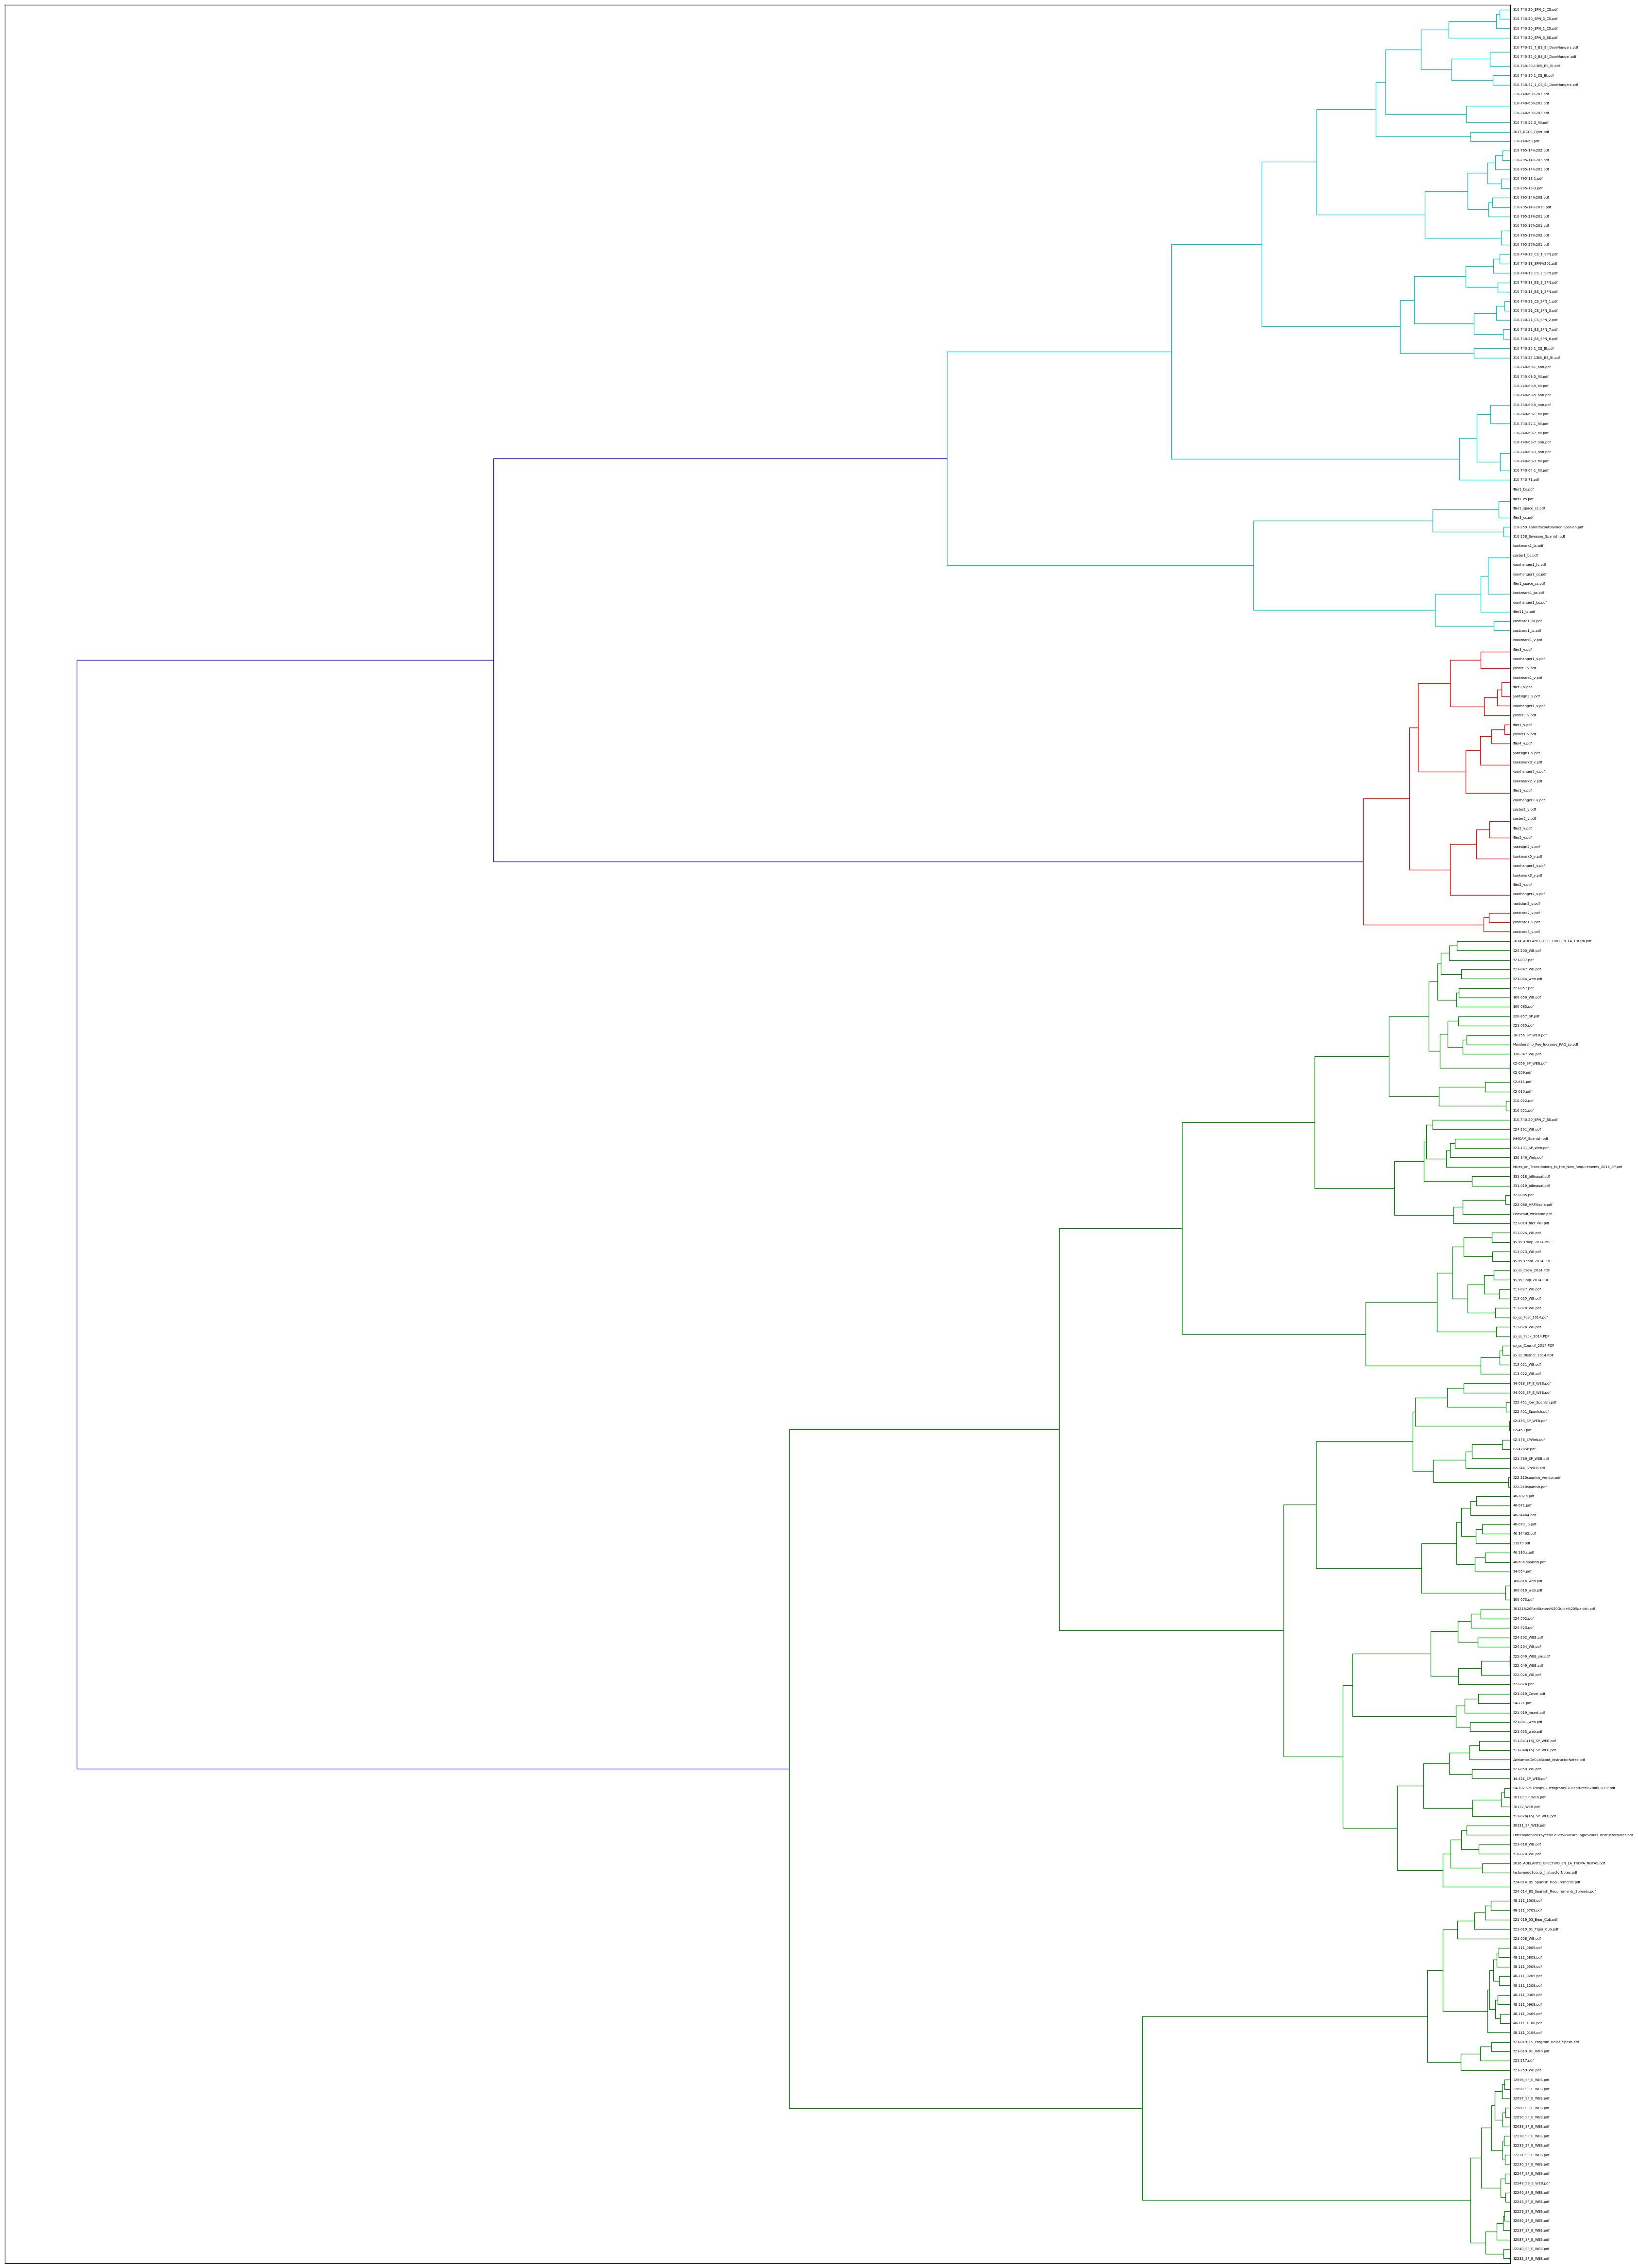

In [30]:
linkage_matrix = ward(spanish_dist)

fig, ax = plt.subplots(figsize = (40,60))
ax = dendrogram(linkage_matrix, orientation="left", labels=spanish_text_names);

plt.tick_params(axis = 'x', which='both', bottom='off', top='off', labelbottom='off')

#plt.tight_layout()

plt.savefig('Spanish_Ward_Clusters.png', dpi = 200)
plt.show()

In [16]:
plt.close()

### Latent Dirichlet Allocation

In [10]:
english_vocab_stemmed = pickle.load(open('english_vocab_stemmed.pickle','r'))
english_vocab_tokenized = pickle.load(open('english_vocab_tokenized.pickle','r'))
spanish_vocab_stemmed = pickle.load(open('spanish_vocab_stemmed.pickle','r'))
spanish_vocab_tokenized = pickle.load(open('spanish_vocab_tokenized.pickle','r'))

In [17]:
gensim_english_text = [[eword for eword in etext if eword not in english_stopwords] for etext in english_vocab_tokenized]
gensim_spanish_text = [[sword for sword in stext if sword not in spanish_stopwords] for stext in spanish_vocab_tokenized]

In [18]:
english_gensim_dictionary = corpora.Dictionary(gensim_english_text)
spanish_gensim_dictionary = corpora.Dictionary(gensim_spanish_text)

In [19]:
english_gensim_dictionary.filter_extremes(no_below=1, no_above = 0.8)
spanish_gensim_dictionary.filter_extremes(no_below=1, no_above = 0.8)

In [ ]:
english_gensim_corpus = [english_gensim_dictionary.doc2bow(etext) for etext in gensim_english_text]
spanish_gensim_corpus = [spanish_gensim_dictionary.doc2bow(stext) for stext in gensim_spanish_text]

In [ ]:
with open("english_gensim_corpus.pkl","w") as eg:
    pickle.dump(english_gensim_corpus, eg)
with open("spanish_gensim_corpus.pkl","w") as es:
    pickle.dump(spanish_gensim_corpus, es)

In [ ]:
english_lda = models.LdaModel(english_gensim_corpus, num_topics=6,
                             id2word=english_gensim_dictionary,
                             update_every = 5,
                             chunksize=10000,
                             passes=100)

In [ ]:
spanish_lda = models.LdaModel(spanish_gensim_corpus, num_topics=4,
                             id2word=spanish_gensim_dictionary,
                             update_every = 5,
                             chunksize = 10000,
                             passes = 100)

In [ ]:
english_lda.show_topics()

english_topics_matrix = english_lda.show_topics(formatted=False, num_words=20)
english_topics_matrix = np.array(english_topics_matrix)

english_topic_words = english_topics_matrix[:,:,1]
for i in english_topic_words:
    print([str(word) for word in i])
    print()

In [ ]:
spanish_lda.show_topics()

spanish_topics_matrix = spanish_lda.show_topics(formatted=False, num_words=20)
spanish_topics_matrix = np.array(spanish_topics_matrix)

spanish_topic_words = spanish_topics_matrix[:,:,1]
for i in spanish_topic_words:
    print([str(word) for word in i])
    print()